In [13]:
import torch
import numpy as np
import os
import os.path as path
import scipy
import pandas as pd
import re

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
def cosine_similarity(x1, x2, dim=1):
    x1_reshaped = x1.reshape(*x1.shape[:2],  -1)
    x2_reshaped = x2.reshape(*x2.shape[:2],  -1)
    return torch.nn.functional.cosine_similarity(torch.Tensor(x1_reshaped), torch.Tensor(x2_reshaped), dim=dim, eps=1e-8).numpy()

def multiple_sample_lineplot(array, *args, **kwargs):
    df = pd.DataFrame(array).reset_index(names="iteration")
    df = pd.melt(df, id_vars="iteration", var_name="sample_id")
    sns.lineplot(df, x="iteration", y="value", *args, **kwargs)

In [19]:
# load gradients
filepath = "../logs/CIFAR10-Ensemble/ensemble/CIFAR10-DCGAN-ens-5-ew-gn-train-2024_05_29_17_17_09/"

npz_file_list = [f for f in os.listdir(filepath) if f.endswith('.npz')]

# dynamically compute number of epochs by number of '.npz'-files
NO_EPOCHS = len(npz_file_list)
EVAL_STEP_SIZE = min([int(re.findall(r"\d+",f)[-1]) for f in npz_file_list])

# construct filenames based of NO_EPOCHS:
filenames = ["fake_sample_grads_" + str(i * EVAL_STEP_SIZE) + ".npz" for i in range(1, NO_EPOCHS+1)]

grads = []
for filename in filenames:
    with np.load(filepath + filename) as grad_file:
        grads.append(grad_file["arr_0"].astype('float16'))
        
# dynamically retrieve number of discriminators from grads file
NO_DISCR = grads[0].shape[1]

# construct pair indices
pair_indices = np.triu_indices(NO_DISCR, k=1)
pair_indices = list(zip(pair_indices[0], pair_indices[1]))

In [20]:
grads[0].shape

(640, 5, 3, 32, 32)

In [22]:
# load Discriminator-Output

filenames = ["Discr_Outs_" + str(i * EVAL_STEP_SIZE) + ".csv" for i in range(1, NO_EPOCHS+1)]

discr_out = []
for filename in filenames:
    discr_out.append(pd.read_csv(filepath + filename, header=None, dtype=np.float16))
    
discr_out = np.stack(discr_out, axis=0)

In [23]:
# Overview and Tensor shapes

grads = np.stack(grads, axis=0)
print("Gradients")
print("Epoch x Sample x Discriminator x Feature")
print(grads.shape)
print()

grads = np.stack(grads, axis=0)
print("Discriminator_Predictions")
print("Epoch x Sample x Discriminator")
print(discr_out.shape)
print()
print("  fake-label: 0, real-label: 0.634 (2 Samples Packed together)")


Gradients
Epoch x Sample x Discriminator x Feature
(100, 640, 5, 3, 32, 32)

Discriminator_Predictions
Epoch x Sample x Discriminator
(100, 640, 5)

  fake-label: 0, real-label: 0.634 (2 Samples Packed together)


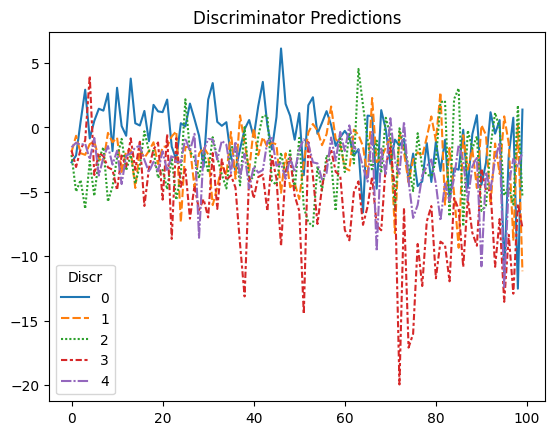

In [24]:
# Plot: Discriminator Predictions

mean_prediction = discr_out.mean(axis=1)
sns.lineplot(mean_prediction)
plt.title("Discriminator Predictions")
plt.legend(title="Discr")
plt.savefig(path.join(filepath, "discr_predicts.pdf"))
plt.show()

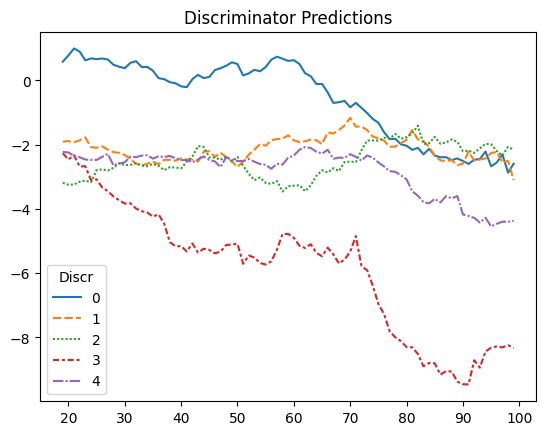

In [25]:
# Plot: Flattened Discriminator Predictions

mean_prediction = discr_out.mean(axis=1)
#sns.lineplot(mean_prediction)
sns.lineplot(pd.DataFrame(mean_prediction).rolling(20).mean())
plt.title("Discriminator Predictions")
plt.legend(title="Discr")
plt.savefig(path.join(filepath, "discr_predict_flat.pdf"))
plt.show()

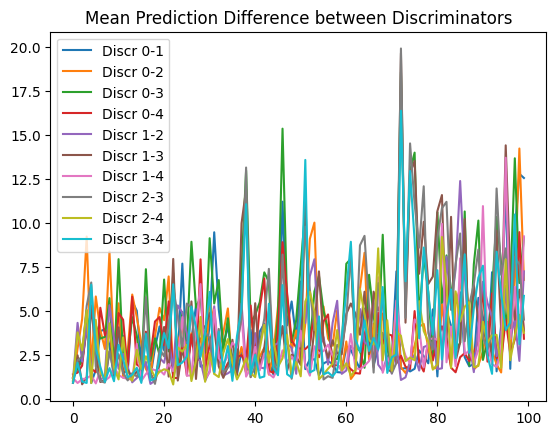

In [26]:
# Plot: Mean Prediction Difference

if NO_DISCR > 1:
    for (i,j) in pair_indices:
        sns.lineplot(np.abs(discr_out[:,:,i] - discr_out[:,:,j]).mean(axis=1), label='Discr {}-{}'.format(i,j))
        plt.title("Mean Prediction Difference between Discriminators")
        plt.legend
    
    plt.savefig(path.join(filepath, "discr_difference.pdf"))
    plt.show()

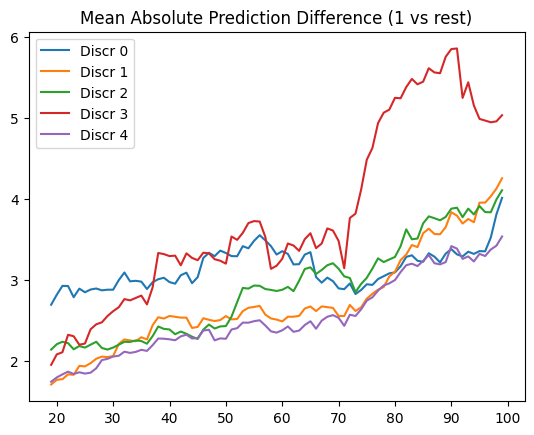

In [27]:
# Plot: Flattened Mean Prediction Difference

if NO_DISCR > 1:
    for i in range(NO_DISCR):
        mean_pred_diff = np.mean(
            [np.abs(discr_out[:,:,i] - discr_out[:,:,j]).mean(axis=1) for j in range(NO_DISCR)],
            axis=0)
        #sns.lineplot(mean_pred_diff, label='Discr {}-{}'.format(i,j))
        sns.lineplot(pd.Series(mean_pred_diff).rolling(20).mean().values, label='Discr {}'.format(i))
        plt.title("Mean Absolute Prediction Difference (1 vs rest)")
        plt.legend
    
    plt.savefig(path.join(filepath, "discr_difference_flat.pdf"))
    plt.show()

In [28]:
# Compute Magnitudes

magnitudes = np.abs(grads).reshape(*grads.shape[:3],  -1) # flatten feature dimensions
magnitudes = magnitudes.mean(axis=1) # mean over samples
aggr_magnitudes = np.abs(grads.reshape(*grads.shape[:3],  -1).mean(axis=-2))
aggr_magnitudes = aggr_magnitudes.mean(axis=1) # mean over samples

#test = grads[:, :, 1]

#print(grads.shape)
#print(magnitudes.shape)
#print(aggr_magnitudes.shape)
#print(test.reshape(*test.shape[:2],  -1).shape)

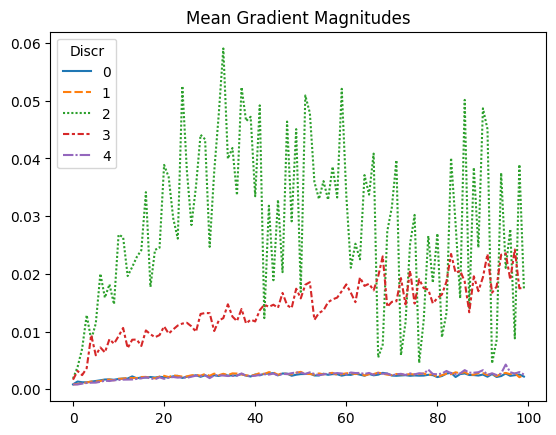

In [29]:
# Plot: Mean Gradient Magnitudes

sns.lineplot(magnitudes.mean(axis=2)) # mean over features
plt.title("Mean Gradient Magnitudes")
plt.legend(title="Discr")
plt.savefig(path.join(filepath, "gradients_mean.pdf"))
plt.show()

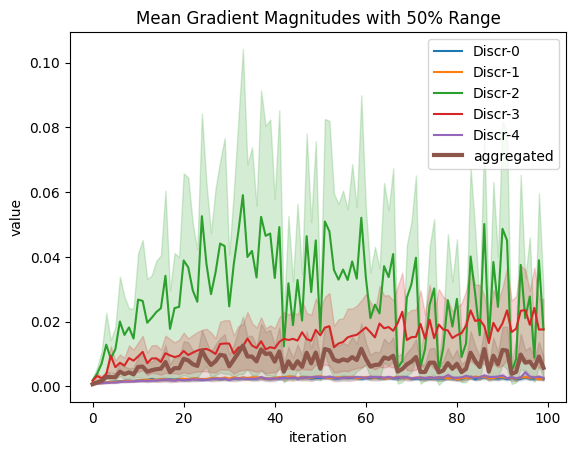

In [30]:
# Plot: Mean Gradient Magnitudes with Range

plt.title("Mean Gradient Magnitudes with 50% Range")
for i in range(NO_DISCR):
    multiple_sample_lineplot(magnitudes[:,i], errorbar=("pi", 50), label='Discr-{}'.format(i))
#add for aggregated Gradients
multiple_sample_lineplot(aggr_magnitudes, errorbar=("pi", 50), linewidth=3, label='aggregated'.format(i))
plt.savefig(path.join(filepath, "gradient_range.pdf"))
plt.show()

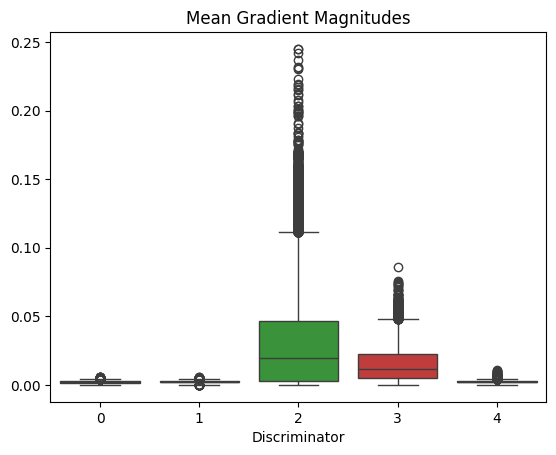

In [31]:
plt.title("Mean Gradient Magnitudes")
sns.boxplot(pd.DataFrame(magnitudes.swapaxes(0,1).reshape(magnitudes.shape[1],-1)).T)
plt.xlabel("Discriminator")
plt.savefig(path.join(filepath, "gradients_box.pdf"))
plt.show()

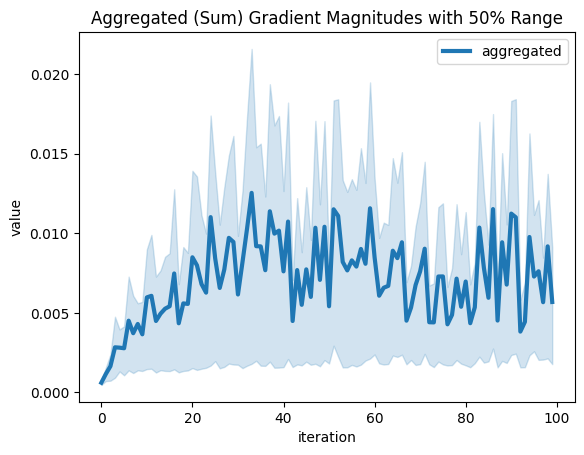

In [32]:
# Plot: Aggregated Gradient Magnitudes with Range

plt.title("Aggregated (Sum) Gradient Magnitudes with 50% Range")
# sum over discriminators, then absolute, then mean overfeatures
multiple_sample_lineplot(aggr_magnitudes, errorbar=("pi", 50), linewidth=3, label='aggregated'.format(i))
plt.savefig(path.join(filepath, "aggr_gradient_range.pdf"))
plt.show()

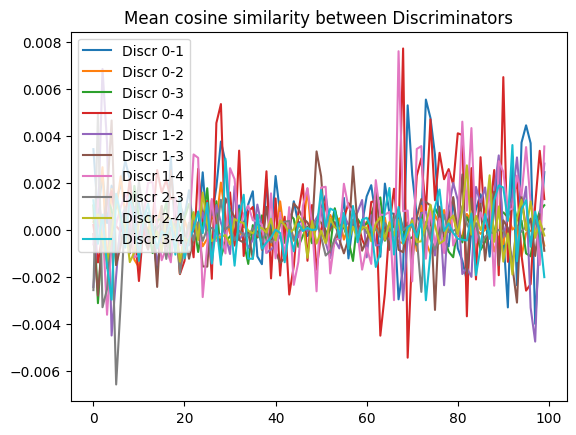

In [33]:
# Plot: Mean Cosine Similarity

#compare Mean Cosine Similarity between pairs of Discriminator
if NO_DISCR > 1:
    cs={}
    for i,j in pair_indices:
        cs[i,j] = cosine_similarity(grads[:, :, i], grads[:, :, j], dim=2)
        sns.lineplot(cs[i,j].mean(axis=1), label='Discr {}-{}'.format(i,j))

    plt.title("Mean cosine similarity between Discriminators")
    plt.legend
    plt.savefig(path.join(filepath, "cosine_simil_mean.pdf"))
    plt.show()

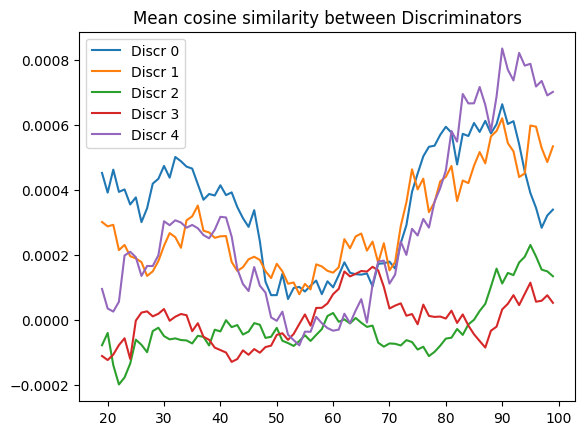

In [34]:
# Plot: Flattened  Mean Cosine Similarity with range

#compare Mean Cosine Similarity between pairs of Discriminator
if NO_DISCR > 1:
    for i in range(NO_DISCR):
        cs_current = np.mean(
            [cosine_similarity(grads[:, :, i], grads[:, :, j], dim=2) for j in range(NO_DISCR) if i != j],
            axis=0)
        #sns.lineplot(cs.mean(axis=1), label='Discr {}'.format(i))
        sns.lineplot(pd.Series(cs_current.mean(axis=1)).rolling(20).mean().values, label='Discr {}'.format(i))

    plt.title("Mean cosine similarity between Discriminators")
    plt.legend
    plt.savefig(path.join(filepath, "cosine_simil_mean_flat.pdf"))
    plt.show()

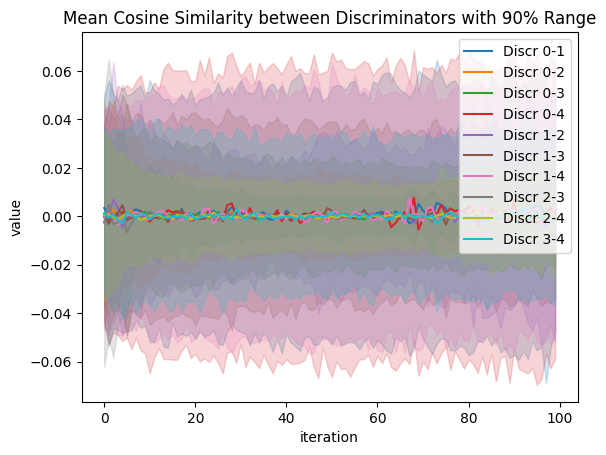

In [35]:
# Plot: Mean Cosine Similarity with Range

if NO_DISCR > 1:
    for i,j in pair_indices:
        multiple_sample_lineplot(cs[i,j], label='Discr {}-{}'.format(i,j), errorbar=("pi", 90))

    plt.title("Mean Cosine Similarity between Discriminators with 90% Range")
    plt.legend
    plt.savefig(path.join(filepath, "cosine_simil_range.pdf"))
    plt.show()

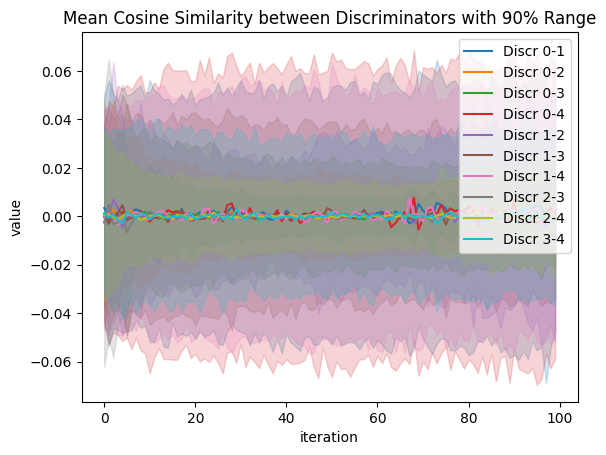

In [36]:
if NO_DISCR > 1:
    for i,j in pair_indices:
        multiple_sample_lineplot(cs[i,j], label='Discr {}-{}'.format(i,j), errorbar=("pi", 90))

    plt.title("Mean Cosine Similarity between Discriminators with 90% Range")
    plt.legend
    #plt.savefig(path.join(filepath, "cosine_simil_range.pdf"))
    plt.show()

### Implementation of GradNorm

In [31]:
def grad_norm(tensor_grad):
    overall_mean = tensor_grad.flatten().abs().mean()
    w = overall_mean / tensor_grad.flatten(1).abs().mean(dim=1)
    view_shape = [-1] + [1] * (tensor_grad.dim() - 1)
    tensor_grad = tensor_grad * w.view(view_shape)
    return tensor_grad

#single epoch Test

tensor_grad = torch.Tensor(grads[0]).transpose(0,1)
print(tensor_grad.shape)
print(tensor_grad.flatten(1).shape)
print(tensor_grad.flatten(1).abs().mean(dim=1))
print(tensor_grad.flatten(1).square().mean(dim=1))
print()

normed_grad = grad_norm(tensor_grad)
print(normed_grad.flatten(1).abs().mean(dim=1))
print(normed_grad.flatten(1).square().mean(dim=1))

torch.Size([5, 640, 3, 32, 32])
torch.Size([5, 1966080])
tensor([0.0009, 0.0008, 0.0018, 0.0017, 0.0008])
tensor([1.4094e-06, 1.3132e-06, 7.4915e-06, 6.1886e-06, 1.2643e-06])

tensor([0.0021, 0.0023, 0.0009, 0.0009, 0.0023])
tensor([8.8581e-06, 9.5073e-06, 1.6666e-06, 2.0174e-06, 9.8749e-06])


tensor([0.0011, 0.0011, 0.0011, 0.0011, 0.0011])


torch.Size([100, 640, 5, 3, 32, 32])